# Getting the Geojson file for Southern California County Subdivisons 

In [1]:
import pandas as pd
import numpy as np
import urllib.request, json, bs4 as bs, requests
import seaborn as sns
import matplotlib.pyplot
import re

## AWATER = area that is water
## ALAND = area that is land
## INTPTLAT is the centroid's latitude
## INTPTLON is the centroid's longitude

In [2]:
## geojson for all California counties
## http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/counties-2012.geojson
## Basic county data (with centroids): https://en.wikipedia.org/wiki/User:Michael_J/County_table


## Subdivisions: 
## http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/county-subdivisions-2012.geojson

## County demographics: 
## Population and Income: 
##https://en.wikipedia.org/wiki/List_of_California_locations_by_income

## California county voter preferences 
## https://en.wikipedia.org/wiki/California_locations_by_voter_registration

## You also have race makeup data from the census 

## Measuring Diversity: http://www.unc.edu/~pmeyer/carstat/tools.html

geojson_url = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/counties-2012.geojson"

# Aquiring and Preprocessing County Demographic Data


In [2]:
basic_county_data_url = "https://en.wikipedia.org/wiki/User:Michael_J/County_table"

basic_county_page_data = requests.get(basic_county_data_url, timeout = 5)

basic_county_page_content = bs.BeautifulSoup(basic_county_page_data.content, "html.parser")


In [3]:
basic_county_data_table = basic_county_page_content.find('table',{'class':'wikitable sortable'})

basic_county_columns = basic_county_data_table.find_all('th')

column_names = []
rows = []

for col in basic_county_columns: 
    
    column_names.append(col.text)
# re.search("\[.*\]|\(.*\)|[mikm].*$", column_names[7])

first_phase_column_names = [re.sub("\[.*\]|\(.*\)|\n","",i) for i in column_names]

second_phase_column_names = [re.sub("mi.*"," (mi2)",i) for i in first_phase_column_names]

third_phase_column_names = [re.sub("km.*"," (km2)",i) for i in second_phase_column_names]

final_column_names = [col.strip() for col in third_phase_column_names]    
    
    
basic_county_raw_rows = basic_county_data_table.find_all('tr')

for row in basic_county_raw_rows[1:]:
    
    rows.append(row.text.split('\n'))

better_rows = []

for row in rows:
    
    better_rows.append([i for i in row if i != ''])
    
string_columns = []

for num in range(len(better_rows[0])):
    
    current_column = []

    for r in range(len(rows)):
        
        current_column.append(better_rows[r][num]) 
        
    string_columns.append(current_column)

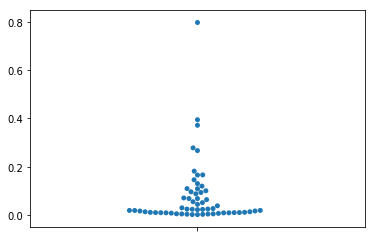

In [4]:
population_numeric = [float(re.sub(',','',i)) for i in string_columns[5]]

landareakm2_numeric = [float(re.sub(',','',i)) for i in string_columns[6]]

landareami2_numeric = [float(re.sub(',','',i)) for i in string_columns[7]]

waterareakm2_prep = [re.sub(',','',i) for i in string_columns[8]]

waterareakm2_prep_final = [re.sub('-',"0",i) for i in waterareakm2_prep]

waterareakm2_numeric = []

for i in waterareakm2_prep_final:
    
    try: 
        waterareakm2_numeric.append(float(i))
    except: 
        
        waterareakm2_numeric.append(None)
        
waterareami2_prep = [re.sub(',','',i) for i in string_columns[9]]

waterareami2_prep_final = [re.sub('-',"0",i) for i in waterareami2_prep]

waterareami2_numeric = []


for i in waterareami2_prep_final:
    
    try: 
        
        waterareami2_numeric.append(float(i))
    
    except: 
        
        waterareami2_numeric.append(None)     
        
        
totalareakm2_numeric = [float(re.sub(',','',i)) for i in string_columns[10]]  
        
totalareami2_numeric = [float(re.sub(',','',i)) for i in string_columns[11]]  

bad_symbol_for_coordinates = string_columns[12][0][len(string_columns[12][0])-1]


lats_numeric = [float(re.sub(bad_symbol_for_coordinates,"",i)) for i in string_columns[12]]


lons_phase_1 = [re.sub(bad_symbol_for_coordinates,"",i) for i in string_columns[13]]

lons_numeric = [float(re.sub(u"\u2013", "-", i)) for i in lons_phase_1]


cleaned_columns = string_columns[0:5]

cleaned_columns.extend((population_numeric, landareakm2_numeric, landareami2_numeric,
                       waterareakm2_numeric, waterareami2_numeric, totalareakm2_numeric,
                       totalareami2_numeric, lats_numeric, lons_numeric))

data_dict = dict(zip(final_column_names,cleaned_columns))


county_census_data = pd.DataFrame(data_dict, columns = final_column_names)


california_county_data = county_census_data.loc[county_census_data['State'] == 'CA',:]
sns.swarmplot(y = california_county_data['Water Area (km2)']
                    /california_county_data['Total Area (km2)'])

In [6]:
california_county_data.to_csv('basic_county_data.csv')